# compute spectra from single drifter tracks

In [1]:
import os
from glob import glob
import pickle

import numpy as np
import xarray as xr
import dask.bag as db
import pandas as pd

from scipy import signal
from mtspec import mtspec
import nitime.algorithms as tsa
from scipy.fftpack import fftfreq

from matplotlib import pyplot as plt
%matplotlib inline

import mitequinox.drifters as edr
import mitequinox.utils as eut

#data_dir = '/work/ALT/swot/aval/syn/drifters/'
data_dir = eut.work_data_dir+'drifters/'

In [2]:
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(cores=6, walltime='12:00:00', memory='20GB')
cluster = PBSCluster()
w = cluster.scale(1*12)
#w = cluster.scale(10) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)
#client = Client()

In [4]:
#client
cluster

In [111]:
#client.close()
cluster.close()

---
## utils

In [5]:
lon_bins = np.arange(-180.5, 180.5, 1.)
lat_bins = np.arange(-90.5, 91.5, 1.)

lon_c = (lon_bins[:-1]+lon_bins[1:])*.5
lat_c = (lat_bins[:-1]+lat_bins[1:])*.5

lon_idx = pd.IntervalIndex.from_breaks(lon_bins)
lat_idx = pd.IntervalIndex.from_breaks(lat_bins)
lonlat_idx = pd.MultiIndex.from_product([lon_idx, lat_idx])

---

## load raw data as xarray dataset and then a dataframe

In [6]:
ds = xr.open_mfdataset(data_dir+'single_tfilt/low_inertial_*.nc', 
                       concat_dim='index', parallel=True)

In [7]:
ds = ds.chunk({'index': 500})
ds['UV'] = (ds.U + 1j * ds.V).where(~np.isnan(ds.U*ds.V), other=np.nan)
ds['f'] = eut.coriolis(ds.LAT, signed=True)
ds['depth'] = edr.compute_depth(ds.LON, ds.LAT)

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/pandas/core/indexes/base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |


In [8]:
ds = ds.persist()

check typical percentages of bad points

(array([   21.,    18.,    13.,    17.,    28.,    32.,    26.,    34.,
           65., 11073.]),
 array([0.9001387 , 0.91012483, 0.92011096, 0.93009709, 0.94008322,
        0.95006935, 0.96005548, 0.97004161, 0.98002774, 0.99001387,
        1.        ]),
 <a list of 10 Patch objects>)

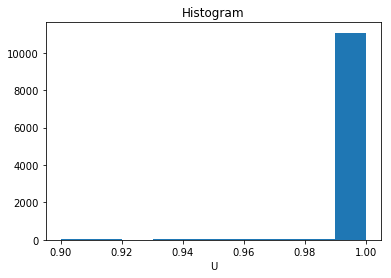

In [9]:
gd_points_percent = ( ds.U.where(np.isnan(ds.U), other=1.)
                      .fillna(0.).sum('TIME')/len(ds.TIME) )
gd_points_percent.plot.hist()

In [11]:
# interpolate NaNs
ds['UV'] = ds.UV.fillna(0.)
# below not working, xarray version issue?
#ds['UV'] = ds.UV.interpolate_na(dim='TIME', method='linear', 
#                                limit=12, right=0., left=0.)

---

## compute spectra

In [45]:
def _get_E(x, method, ufunc=True, **kwargs):
    if method=='welch':
        ax = -1 if ufunc else 0
        ax = -1
        dkwargs = {'window': 'hann', 'return_onesided': False, 
                   'detrend': 'linear', 'scaling': 'density'}
        dkwargs.update(kwargs)
        f, E = signal.periodogram(x, fs=24., axis=ax, **dkwargs)
    elif method=='mtspec':
        E = []
        for i in range(x.shape[0]):
                lE, f = mtspec(data=x[i,:], delta=1/24., time_bandwidth=4.,
                               number_of_tapers=6, quadratic=True)
                E+=[lE[None,:]]
        E = np.concatenate(E,axis=0)
    elif method=='mt':
        lf, E, nu = tsa.multi_taper_psd(x, Fs=24., NW=2, sides='twosided',
                                       adaptive=False, jackknife=False)
        f = fftfreq(len(lf))*24.
        # http://nipy.org/nitime/examples/multi_taper_spectral_estimation.html
        #print('Number of tapers = %d' %(nu[0]/2))
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    Nb = len(v.TIME)
    dkwargs = {'method': 'welch'}
    dkwargs.update(kwargs)
    if dkwargs['method']=='mtspec':
        Nb = 361
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **dkwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['TIME']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=dkwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

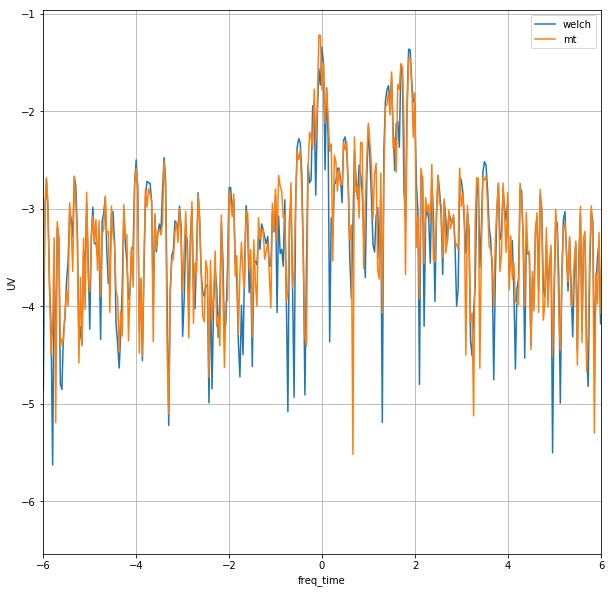

In [46]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
for method in ['welch','mt']:
    _uv = ds.UV.isel(index=slice(0,10))
    f, E = get_E(_uv, method=method)
    E = get_E(_uv, f=f, method=method)
    np.log10(E).isel(index=1).plot.line(x='freq_time', label=method)
ax.set_xlim(-6,6)
ax.grid()
ax.legend()

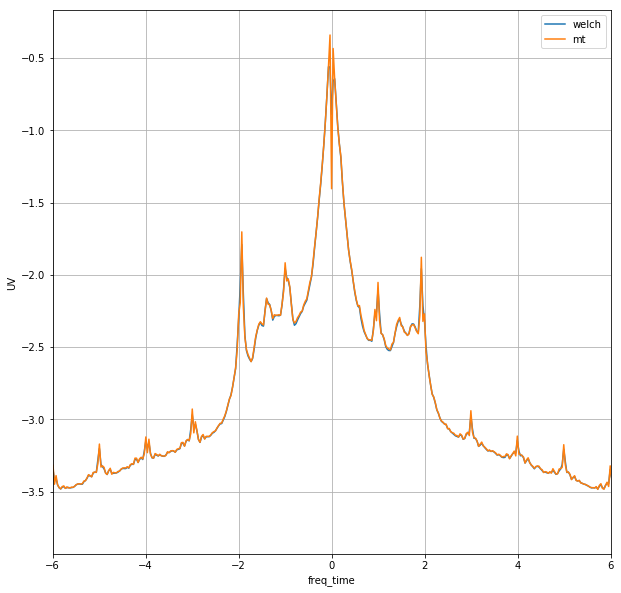

In [47]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
for method in ['welch','mt']:
    _uv = ds.UV
    f, E = get_E(_uv, method=method)
    E = get_E(_uv, f=f, method=method)
    np.log10(E.mean('index')).plot.line(x='freq_time', label=method)
ax.set_xlim(-6,6)
ax.grid()
ax.legend()

## bin per latitude

In [48]:
method='welch'
f, E = get_E(ds.UV, method=method)
ds['E'] = get_E(ds.UV, f=f, method=method)

In [49]:
#ds = ds.isel(index=slice(0,1000))

In [50]:
ds = ds.assign_coords(LAT_mean=ds.LAT.mean('TIME'))
ds = ds.assign_coords(depth_mean=ds.depth.mean('TIME'))

In [51]:
ds = ds.where(ds.depth_mean>500, drop=True)

In [52]:
E = (ds.E.groupby_bins(ds.LAT_mean, lat_bins, labels= lat_c).mean(dim='index')
     .rename({'LAT_mean_bins': 'lat'}).persist() )
E

<xarray.DataArray 'E' (lat: 181, freq_time: 721)>
dask.array<shape=(181, 721), dtype=float64, chunksize=(14, 721)>
Coordinates:
  * lat        (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * freq_time  (freq_time) float64 -11.98 -11.95 -11.92 ... 11.92 11.95 11.98

(-5, 5)

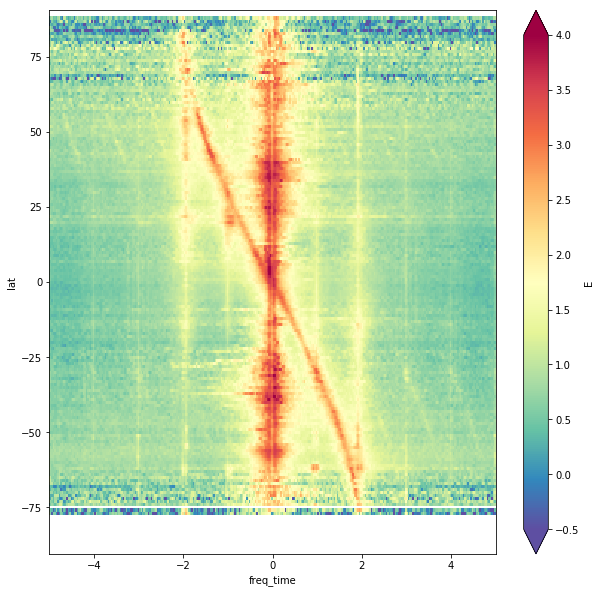

In [53]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
( np.log10(E*1e4).plot(ax=ax, vmin=-.5, vmax=4.,cmap='Spectral_r') )
ax.set_xlim([-5,5])

In [54]:
E['f'] = eut.coriolis(E.lat, signed=True)
E['f_cpd'] = E.f*86400./2./np.pi
E['nfreq_time'] = E.freq_time / E.f_cpd

(-3, 3)

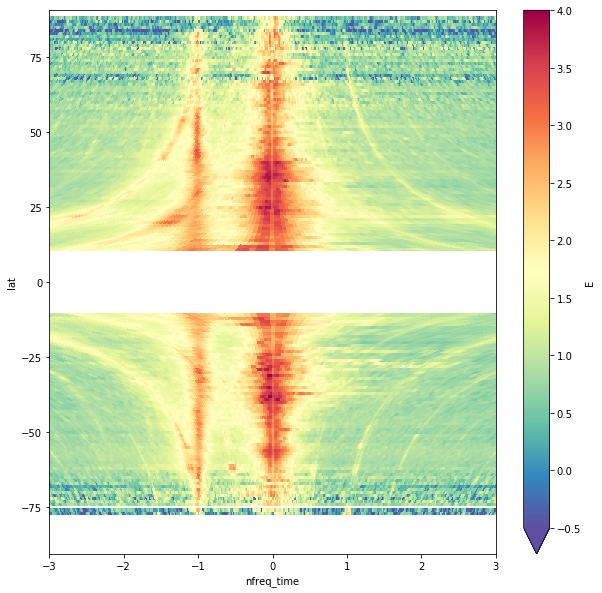

In [55]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
( np.log10(E.where(E.lat>10, drop=True)*1e4)
 .plot(ax=ax, x='nfreq_time', y='lat', 
                       vmin=-.5, vmax=4.,cmap='Spectral_r') )
( np.log10(E.where(E.lat<-10, drop=True)*1e4)
 .plot(ax=ax, x='nfreq_time', y='lat', 
                       vmin=-.5, vmax=4.,cmap='Spectral_r', add_colorbar=False) )
ax.set_xlim([-3,3])

## find inertial peak and bandwidth

In [56]:
dE = E.to_dataset()

In [57]:
dE

<xarray.Dataset>
Dimensions:     (freq_time: 721, lat: 181)
Coordinates:
  * lat         (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * freq_time   (freq_time) float64 -11.98 -11.95 -11.92 ... 11.92 11.95 11.98
    f           (lat) float64 -0.0001458 -0.0001458 ... 0.0001458 0.0001458
    f_cpd       (lat) float64 -2.005 -2.005 -2.004 -2.003 ... 2.004 2.005 2.005
    nfreq_time  (freq_time, lat) float64 5.975 5.976 5.979 ... 5.979 5.976 5.975
Data variables:
    E           (lat, freq_time) float64 dask.array<shape=(181, 721), chunksize=(14, 721)>

In [58]:
imax = ( dE.E.where(np.abs(dE.freq_time + dE.f_cpd)<.2).fillna(-1.)
                 .argmax('freq_time') )
dE['freq_max'] = dE.freq_time.isel(freq_time=imax).rename('freq_max')
dE['Emax'] = dE.E.isel(freq_time=imax)

In [59]:
Ei = (dE.where(np.abs(dE.freq_time - dE.freq_max)<1.)
      .where(dE.freq_time>dE.freq_max)) #.fillna(-1.)
Ei_rev = (dE.where(np.abs(dE.freq_time - dE.freq_max)<1.)
            .where(dE.freq_time<dE.freq_max) #.fillna(1e10)
            .sortby('freq_time', ascending=False) )
dE['freq_half_1'] = Ei.freq_time.isel(freq_time=(Ei.E<Ei.Emax/2.).argmax('freq_time'))
dE['freq_half_0'] = Ei_rev.freq_time.isel(freq_time=(Ei_rev.E<Ei_rev.Emax/2.).argmax('freq_time'))

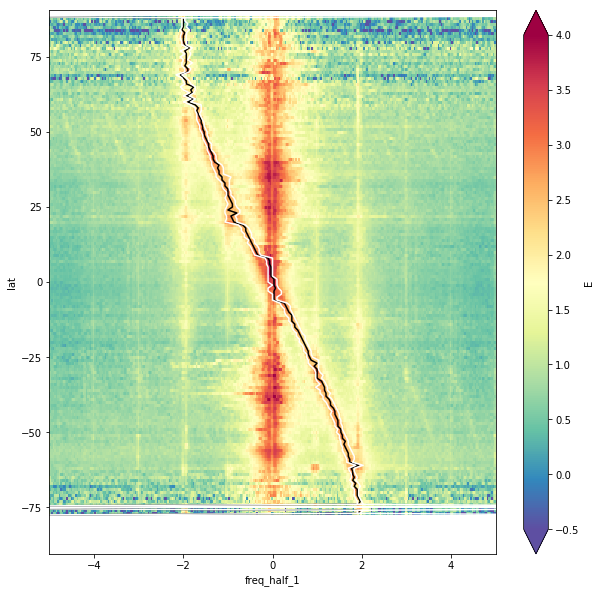

In [60]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
( np.log10(dE.E*1e4).plot(ax=ax, vmin=-.5, vmax=4.,cmap='Spectral_r') )
ax.set_xlim([-5,5])

dE.freq_max.plot(y='lat',color='k')
dE.freq_half_0.plot(y='lat',color='w')
dE.freq_half_1.plot(y='lat',color='w')

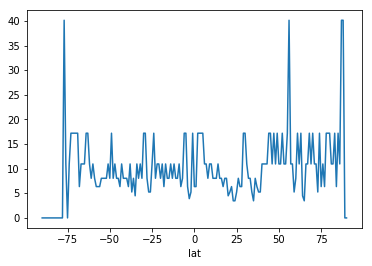

In [62]:
(1./(dE.freq_half_1-dE.freq_half_0-1/24.)).plot()

In [63]:
dE = dE.persist()

(-6.0, 6.0)

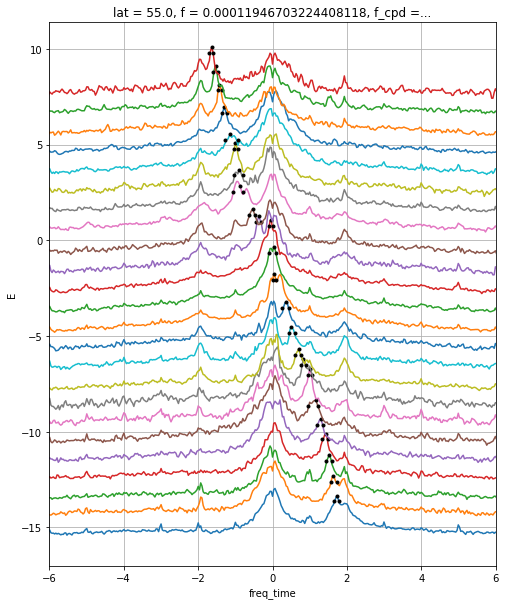

In [64]:
fig, ax = plt.subplots(1,1,figsize=(8,10))
for lat in np.arange(-60.,60.,5.):
    offset = lat/5.
    (np.log10(dE.E.sel(lat=lat))+offset).plot(ax=ax) #,color='k')
    ax.plot(dE.freq_max.sel(lat=lat), (np.log10(dE.Emax.sel(lat=lat))+offset), 
            marker='.',color='k')
    #ax.plot(dE.freq_max.sel(lat=lat), (np.log10(dE.Emax.sel(lat=lat)/2.)+offset), 
    #        marker='.',color='k')
    ax.plot(dE.freq_half_0.sel(lat=lat), (np.log10(dE.Emax.sel(lat=lat)/2.)+offset), 
            marker='.',color='k')
    ax.plot(dE.freq_half_1.sel(lat=lat), (np.log10(dE.Emax.sel(lat=lat)/2.)+offset), 
            marker='.',color='k')
ax.grid()
ax.set_xlim(-6.,6.)

---

## store dataset

In [47]:
# store
ds.to_netcdf(data_dir+'single_stats.nc', mode='w')
ds

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360)
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    U        (lon, lat) float64 nan nan nan nan ... nan -0.02582 0.2797 -0.0807
    V        (lon, lat) float64 nan nan nan nan ... nan 0.1025 -0.0283 -0.053
    U2       (lon, lat) float64 nan nan nan nan ... nan 0.01712 0.07918 0.006512
    V2       (lon, lat) float64 nan nan nan nan ... 0.01571 0.0008749 0.002809
    UV       (lon, lat) float64 nan nan nan nan ... -0.001538 -0.008177 0.004277
    COUNT    (lon, lat) float64 nan nan nan nan nan nan ... nan nan 26.0 2.0 1.0
    depth    (lon, lat) float64 2.792e+03 2.983e+03 ... -2.728e+03 -4.22e+03

In [65]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
